In [30]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections
import requests
import base64

from pandas.tools.plotting import scatter_matrix
import nltk
from ast import literal_eval
from datetime import timedelta
import string

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl

In [31]:
# create loader object
L = instaloader.Instaloader()

#Set PANDAS to show all columns in DataFrame
# pd.set_option('display.max_columns', None)
# plt.rcParams['figure.figsize'] = (15, 5)

UTC_FILE_NAME = "_UTC"
COMMENTS_FILE_NAME = "_comments"
FILE_ADDRESS_NAME = "InstagramLog/"


DONALD_TRUMP = 'realdonaldtrump'
DONALD_TRUMP_NAME = 'President Donald J. Trump'
DONALD_TRUMP_BIO = '45th President of the United States'
DONALD_TRUMP_COLOR = '#446fc4'
DONALD_TRUMP_TRAIN_SET = DONALD_TRUMP_NAME + DONALD_TRUMP + DONALD_TRUMP_BIO + 'president of the united state of america.'

BARACK_OBAMA = 'barackobama'
BARACK_OBAMA_NAME = 'Barack Obama'
BARACK_OBAMA_BIO = 'Dad, husband, President, citizen.'
BARACK_OBAMA_COLOR = '#7f2d9b'
BARACK_OBAMA_TRAIN_SET = BARACK_OBAMA + BARACK_OBAMA_NAME + BARACK_OBAMA_BIO + '44th President of the United States.'

EMMANUEL_MACRON = 'emmanuelmacron'
EMMANUEL_MACRON_NAME = 'Emmanuel Macron'
EMMANUEL_MACRON_BIO = 'Président de la République française.'
EMMANUEL_MACRON_COLOR = '#369b4f'
EMMANUEL_MACRON_TRAIN_SET = EMMANUEL_MACRON + EMMANUEL_MACRON_NAME + EMMANUEL_MACRON_BIO

#politicians
DONALD_TRUMP = 'realdonaldtrump'
BARACK_OBAMA = 'barackobama'
EMMANUEL_MACRON = 'emmanuelmacron'
THERESA_MAY = 'theresamay'
FLOTUS = 'flotus'

#news agencies
CNN = 'cnn'
FOXNEWS = 'foxnews'
BBC = 'bbcnews'
REUTERS = 'reuters'
GOAL_COM = 'goalglobal' #sport

# sport stars
LEOMESSI = 'leomessi'
CRISTIANO_RONALDO = 'cristiano'
RAFAEL_NADAL = 'rafaelnadal'
ROGER_FEDERER = 'rogerfederer'
NOVAK_DJOKOVIC = 'djokernole'

POLITICIAN = [DONALD_TRUMP, BARACK_OBAMA, EMMANUEL_MACRON, THERESA_MAY]
NEWS_AGENCY = [CNN, BBC, FOXNEWS, REUTERS]
SPROTS_STAR = [LEOMESSI, CRISTIANO_RONALDO, ROGER_FEDERER, RAFAEL_NADAL]


# MongoDB Database
instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
instagram_db = instagramClient["Instagram"]
instagram_col_post = instagram_db["Post"]
instagram_col_comment = instagram_db["Comment"]
instagram_col_like = instagram_db["Like"]
instagram_col_analyse = instagram_db["Analyse"]
instagram_col_mentioned_in_comment = instagram_db["MentionedInComment"]

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/koosha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/koosha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
df_clustered = pd.read_csv('clustered_data_new.csv')
print(df_clustered.shape[0])

3832


In [33]:
def get_post_date(_row):
    
    date_list = []
    
    if (not _row['comment_total'] == 0):
        
        post_shortcodes = _row['comment_post_shortcode'].split(",,,")
         
        for shortcode in post_shortcodes:
            post = instagram_col_post.find_one( { "shortcode" : shortcode }, {'date_utc': 1} )
            date_list.append(post['date_utc'])

    myString = ",,,".join(date_list)
    _row['comment_post_date'] = myString
        
    return _row

In [34]:
df_clustered = df_clustered.apply(get_post_date, axis=1)

In [35]:
def calculate_age(_row):
       
    list_diff_in_sec = []
    avg = 0
      
    if (not _row['comment_total'] == 0):
        
        post_dates = _row['comment_post_date'].split(",,,")
        comment_dates =  _row['comment_created_at'].split(",,,")
        
        total_diff_in_second = 0
        
        for i in range(len(post_dates)):
            
            post_time = pd.to_datetime(post_dates[i], format='%Y-%m-%d %H:%M:%S')
            comment_time = pd.to_datetime(comment_dates[i], format='%Y-%m-%d %H:%M:%S')
            
            dif = (comment_time - post_time)
#             time_difference_in_minutes = dif / timedelta(minutes=1)
            total_diff_in_second += dif.total_seconds()
            list_diff_in_sec.append(str(dif.total_seconds()))
#             sec = timedelta(seconds=list_diff[0])
#             time = str(sec)
#             print(time)

        avg = total_diff_in_second / len(post_dates)
    
    _row['comment_avg_age_sec'] = avg
    
    myString = ",,,".join(list_diff_in_sec)
    _row['comment_age_sec'] = myString

    return _row

In [36]:
df_clustered = df_clustered.apply(calculate_age, axis=1)

In [37]:
df_clustered.columns

Index(['Unnamed: 0', 'username', 'name', 'bio', 'photo', 'nfollower',
       'nfollowee', 'nmediacount', 'follower', 'followee', 'mediacount',
       'private', 'verified', 'lcm', 'mcm', 'nmcm', 'class', 'class BGM 3',
       'class GM 3', 'class kmeans 3', 'class spectral 3', 'class GM 4',
       'owener_id', 'combined_owener_external_url', 'combined_username',
       'combined_full_name', 'combined_profile_pic_url', 'combined_biography',
       'combined_similarity_photo_comment', 'combined_similarity_photo_like',
       'comment_created_at', 'comment_id', 'comment_post_shortcode',
       'comment_shortcode_username', 'comment_text', 'comment_total',
       'like_total', 'like_shortcode_username', 'like_post_shortcode',
       'like_id', 'comment_post_date', 'comment_avg_age_sec',
       'comment_age_sec'],
      dtype='object')

In [38]:
df_clustered['comment_shortcode_username'] = df_clustered['comment_shortcode_username'].fillna("--")
df_clustered['like_shortcode_username'] = df_clustered['like_shortcode_username'].fillna("--")

In [39]:
def get_comment_post_username_list(_row):
    
    _row['comment_shortcode_username_list'] = []
    
    if (not _row['comment_shortcode_username']=="--"):
        usernames = _row['comment_shortcode_username'].split(",,,")  
        _row['comment_shortcode_username_list'] = usernames
    
    return _row
    
df_clustered = df_clustered.apply(get_comment_post_username_list, axis=1)

In [40]:
def get_like_post_username_list(_row):
    
    _row['like_shortcode_username_list'] = []
    
    if (not _row['like_shortcode_username']=="--"):
        usernames = _row['like_shortcode_username'].split(",,,")  
        _row['like_shortcode_username_list'] = usernames
    
    return _row
    
df_clustered = df_clustered.apply(get_like_post_username_list, axis=1)

In [41]:
df_clustered.head()

Unnamed: 0  username  name       bio  photo  nfollower  nfollowee  \
0           0  0.303216   0.0  0.000000      0   0.000022   0.052744   
1           1  0.000000   0.0  0.379978      0   0.002047   0.181007   
2           2  0.000000   0.0  0.407353      0   0.000332   0.131993   
3           3  0.000000   0.0  0.482680      0   0.000162   0.079382   
4           4  0.000000   0.0  0.303216      0   0.000061   0.055940   

   nmediacount  follower  followee  \
0     0.006037       170       396   
1     0.013694     15659      1359   
2     0.015847      2539       991   
3     0.011386      1240       596   
4     0.003862       468       420   

                         ...                          comment_total  \
0                        ...                                      0   
1                        ...                                      0   
2                        ...                                      0   
3                        ...                                      3   
4                        ...                                      0   

   like_total                            like_shortcode_username  \
0           0                                            foxnews   
1           0                                            reuters   
2           0  emmanuelmacron,,,emmanuelmacron,,,emmanuelmacr...   
3           1                                    realdonaldtrump   
4           0                                            reuters   

                                 like_post_shortcode  \
0                                        Bqx7XNahvfY   
1                                        Br8XsKaFUIc   
2  BqUv1eonVJQ,,,BqUrbhqHY9X,,,BqNGePuFrq0,,,BqDc...   
3                                        Bpe4fLZApVQ   
4                                        Br-5eUAlbwA   

                                             like_id  \
0                           5c45d2950c2acb018cef1933   
1                           5cb4d9b4b5d85c11bf444a63   
2  5c13dbc30c2acb135537daec,,,5c13e8eb0c2acb13553...   
3                           5be46d700c2acb7ef4464bb7   
4                           5cb4d8b9b5d85c11bf44353a   

                                   comment_post_date comment_avg_age_sec  \
0                                                               0.000000   
1                                                               0.000000   
2                                                               0.000000   
3  2018-11-29 14:16:09,,,2018-11-29 14:16:09,,,20...        18987.666667   
4                                                               0.000000   

               comment_age_sec  \
0                                
1                                
2                                
3  18915.0,,,19006.0,,,19042.0   
4                                

                     comment_shortcode_username_list  \
0                                                 []   
1                                                 []   
2                                                 []   
3  [realdonaldtrump, realdonaldtrump, realdonaldt...   
4                                                 []   

                        like_shortcode_username_list  
0                                          [foxnews]  
1                                          [reuters]  
2  [emmanuelmacron, emmanuelmacron, emmanuelmacro...  
3                                  [realdonaldtrump]  
4                                          [reuters]  

[5 rows x 45 columns]

In [42]:
class_method = 'class kmeans 3'
df_grouped = df_clustered.groupby(class_method)
groups = df_grouped.groups
groups.keys()

dict_keys([0, 1, 2])

In [44]:
grouped_c0_fan = df_grouped.get_group(1)
grouped_c1_ordinary = df_grouped.get_group(0)
grouped_c2_botlike = df_grouped.get_group(2)

c0_name_fan = 'C0-Fan-page'
c1_name_ordinary = 'C1-Ordinary-User'
c2_name_botlike = 'C2-Botlike'

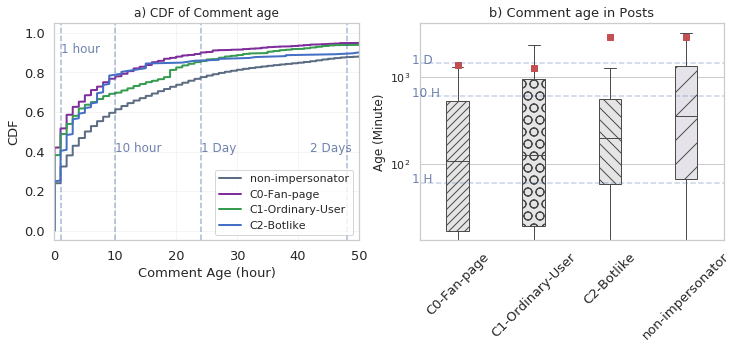

In [71]:
def plot_1():
    
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    
    #all
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find( 
                {
            "$or": [
                        {'owner_username': CRISTIANO_RONALDO},
                        {'owner_username': BARACK_OBAMA},
                        {'owner_username': EMMANUEL_MACRON},
                        {'owner_username': RAFAEL_NADAL},
                        {'owner_username': BBC},
                    ]
        }
        , {'shortcode': 1, 'date_utc': 1}
    )

    list_all_periods = []

    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')

        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))
        data =  pd.DataFrame(comments)
        
        #check if it is empty
        if (data.shape[0] == 0):
            continue
        
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        diff = (data_new['created_at'] - post_time).dt.total_seconds()

        list_all_periods.extend(diff)


    list_all_periods_hour = []
    list_all_periods_minute = []
    for i in list_all_periods:
        # Obtain the total minutes
        totalMinutes = i // 60
        # Obtain the total hours
        totalHours = totalMinutes // 60
    #     sec = timedelta(seconds=i)
        totalday = totalHours // 24
        
        list_all_periods_minute.append(totalMinutes)
        list_all_periods_hour.append(totalHours)


    datad_all =  pd.DataFrame(list_all_periods_minute)
    datad_all.columns = ['period']

    datad =  pd.DataFrame(list_all_periods_hour)
    datad.columns = ['period']
    ser = datad[['period']].copy()
    ser = ser.sort_values(by='period')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)   
    ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1, legend=True, label='non-impersonator', c="#5c6c82") 
    
    
    

    # cluster 0
    list_imposter_all = []
    for i in grouped_c0_fan['comment_age_sec']:
        if (not i == ""):
            posts = i.split(",,,")
            list_imposter_all.extend(posts)

    list_imposter_all = list(map(float, list_imposter_all))
    list_impostor_day = []
    list_impostor_min = []
    
    for i in list_imposter_all:
        # Obtain the total minutes
        totalMinutes = i // 60
        # Obtain the total hours
        totalHours = totalMinutes // 60
    #     sec = timedelta(seconds=i)
        totalday = totalHours // 24
        list_impostor_min.append(totalMinutes)
        list_impostor_day.append(totalHours)

    datam0 =  pd.DataFrame(list_impostor_min)
    datam0.columns = ['period']
    # print(list_impostor_day)
    data =  pd.DataFrame(list_impostor_day)
    data.columns = ['period']
    ser = data[['period']].copy()
    ser = ser.sort_values(by='period')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1, legend=True, label=c0_name_fan, c="#7f2d9b")
    

    
    # cluster 1
    list_imposter_all = []
    for i in grouped_c1_ordinary['comment_age_sec']:
        if (not i == ""):
            posts = i.split(",,,")
            list_imposter_all.extend(posts)

    list_imposter_all = list(map(float, list_imposter_all))
    list_impostor_day = []
    list_impostor_min = []
    
    for i in list_imposter_all:
        # Obtain the total minutes
        totalMinutes = i // 60
        # Obtain the total hours
        totalHours = totalMinutes // 60
    #     sec = timedelta(seconds=i)
        totalday = totalHours // 24
        list_impostor_min.append(totalMinutes)
        list_impostor_day.append(totalHours)

    datam1 =  pd.DataFrame(list_impostor_min)
    datam1.columns = ['period']
    # print(list_impostor_day)
    data =  pd.DataFrame(list_impostor_day)
    data.columns = ['period']
    ser = data[['period']].copy()
    ser = ser.sort_values(by='period')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1, legend=True, label=c1_name_ordinary, c="#369b4f")
    
    
    
    # cluster 2
    list_imposter_all = []
    for i in grouped_c2_botlike['comment_age_sec']:
        if (not i == ""):
            posts = i.split(",,,")
            list_imposter_all.extend(posts)

    list_imposter_all = list(map(float, list_imposter_all))
    list_impostor_day = []
    list_impostor_min = []
    
    for i in list_imposter_all:
        # Obtain the total minutes
        totalMinutes = i // 60
        # Obtain the total hours
        totalHours = totalMinutes // 60
    #     sec = timedelta(seconds=i)
        totalday = totalHours // 24
        list_impostor_min.append(totalMinutes)
        list_impostor_day.append(totalHours)

    datam2 =  pd.DataFrame(list_impostor_min)
    datam2.columns = ['period']
    # print(list_impostor_day)
    data =  pd.DataFrame(list_impostor_day)
    data.columns = ['period']
    ser = data[['period']].copy()
    ser = ser.sort_values(by='period')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
#     ser_cdf.index.name = "Comment Age (hour)"    
    ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1, legend=True, label=c2_name_botlike, c="#446fc4")
    ax5.axes.set_xlim([0,50])
    
    for item in ([ax5.title, ax5.xaxis.label, ax5.yaxis.label] + ax5.get_xticklabels() + ax5.get_yticklabels()): item.set_fontsize(13)
        
    ax5.set_ylabel("CDF")
    ax5.set_xlabel("Comment Age (hour)")
    ax5.set_title("a) CDF of Comment age")
    
    
    ax5.axvline(x=1, linestyle='dashed', alpha=0.5)
    ax5.text(x=1, y=0.9, s='1 hour', alpha=0.7, color='#334f8d')

    ax5.axvline(x=10, linestyle='dashed', alpha=0.5)
    ax5.text(x=10, y=0.4, s='10 hour', alpha=0.7, color='#334f8d')
    
    ax5.axvline(x=24, linestyle='dashed', alpha=0.5)
    ax5.text(x=24, y=0.4, s='1 Day', alpha=0.7, color='#334f8d')
    
    ax5.axvline(x=48, linestyle='dashed', alpha=0.5)
    ax5.text(x=42, y=0.4, s='2 Days', alpha=0.7, color='#334f8d')
    
    ax5.grid(True, which='both', linestyle='-', alpha=0.2)
    
    
    
    # #     boxplot = data.boxplot(ax=ax2, showfliers=False)
    s1 = datam0['period']
    s1.name = c0_name_fan

    s2 = datam1['period']
    s2.name = c1_name_ordinary
    
    s3 = datam2['period']
    s3.name = c2_name_botlike
    
    s4 = datad_all['period']
    s4.name = 'non-impersonator'
    
    
    data3 = pd.concat([s1, s2, s3, s4], axis=1)

    boxplot2 = sns.boxplot( data=data3, showfliers=False, width= 0.3, linewidth=1, ax=ax2)
    boxplot2.plot(data3.mean(), 'rs')
#     boxplot2.set_xlabel("Clusters")
    boxplot2.set_ylabel("Age (Minute)")
    boxplot2.set_yscale('log')
    boxplot2.set_title("b) Comment age in Posts")
    
    
    boxplot2.xaxis.set_tick_params(rotation=45)
    
    mybox = boxplot2.artists[0]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '///')

    mybox = boxplot2.artists[1]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = 'O')

    mybox = boxplot2.artists[2]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '\\\ ' )

    mybox = boxplot2.artists[3]
    mybox.set_facecolor('#e5e3e9')
    mybox.set(hatch = '(/')
    
    boxplot2.axhline(60, linestyle='dashed', alpha=0.3)
    boxplot2.text(y=60, x=-0.6, s='1 H', alpha=0.7, color='#334f8d')
    
    boxplot2.axhline(600, linestyle='dashed', alpha=0.3)
    boxplot2.text(y=600, x=-0.6, s='10 H', alpha=0.7, color='#334f8d')
    
    boxplot2.axhline(1440, linestyle='dashed', alpha=0.3)
    boxplot2.text(y=1440, x=-0.6, s='1 D', alpha=0.7, color='#334f8d')
    
    for item in ([boxplot2.title] + boxplot2.get_xticklabels()): item.set_fontsize(13)
    
    plt.savefig("plot_MLearning9_P1.pdf", bbox_inches='tight')
    
plot_1()

In [47]:
def plot_1_2():
    
    fig, (ax1) = plt.subplots(1,1, figsize=(6,4))

    s1 = grouped_c0_fan['mediacount']
    s1.name = c0_name_fan

    s2 = grouped_c1_ordinary['mediacount']
    s2.name = c1_name_ordinary

    s3 = grouped_c2_botlike['mediacount']
    s3.name = c2_name_botlike

    data3 = pd.concat([s1, s2, s3], axis=1)
    boxplot2 = sns.boxplot( data=data3, showfliers=False, width= 0.3, linewidth=1, ax=ax1)
    
plot_1_2()

In [50]:
print(grouped_c0_fan.shape[0])
print(grouped_c1_ordinary.shape[0])
print(grouped_c2_botlike.shape[0])

2102
1337
393


In [51]:
print(grouped_c0_fan['comment_total'].mean())
print(grouped_c1_ordinary['comment_total'].mean())
print(grouped_c2_botlike['comment_total'].mean())

1.1988582302568982
1.5699326851159312
0.544529262086514


In [52]:
print(grouped_c0_fan['like_total'].mean())
print(grouped_c1_ordinary['like_total'].mean())
print(grouped_c2_botlike['like_total'].mean()) 

0.4738344433872502
0.4869109947643979
0.26717557251908397


In [53]:
def get_amount_of_unique_user_per_community_comment(_group, _type):
    
    if (_type == 'like'):
        list_usernames = _group['like_shortcode_username_list']
        
    if (_type == 'comment'):
        list_usernames = _group['comment_shortcode_username_list']

    total_politician = 0
    total_sportstar = 0
    total_newsagency = 0

    for i in list_usernames:
        
        politcian = 0
        sport_Star = 0
        news_agency = 0
            
        if (len(i) > 0 ):
            for j in i:
                if (j in POLITICIAN):
                    politcian = 1
                if (j in NEWS_AGENCY):
                    news_agency = 1
                if (j in SPROTS_STAR):
                    sport_Star = 1

        total_politician += politcian
        total_sportstar += sport_Star
        total_newsagency += news_agency
    
    return total_politician , total_sportstar, total_newsagency

In [54]:
def get_cumulative_reaction_per_community(_group, _type):
    
    if (_type == 'like'):
        list_usernames = _group['like_shortcode_username_list']
        
    if (_type == 'comment'):
        list_usernames = _group['comment_shortcode_username_list']

    total_politician = 0
    total_sportstar = 0
    total_newsagency = 0

    for i in list_usernames:
        
        politcian = 0
        sport_Star = 0
        news_agency = 0
            
        if (len(i) > 0 ):
            for j in i:
                if (j in POLITICIAN):
                    politcian += 1
                if (j in NEWS_AGENCY):
                    news_agency += 1
                if (j in SPROTS_STAR):
                    sport_Star += 1

        total_politician += politcian
        total_sportstar += sport_Star
        total_newsagency += news_agency
    
    return total_politician , total_sportstar, total_newsagency

In [82]:
# comment
total_ordinary = grouped_c1_ordinary.shape[0]
total_fan_page = grouped_c0_fan.shape[0]
total_bot = grouped_c2_botlike.shape[0]

fanpage_politician , fanpage_sportstar, fanpage_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c0_fan, 'comment')
ordinary_politician , ordinary_sportstar , ordinary_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c1_ordinary, 'comment')
bot_politician , bot_sportstar, bot_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c2_botlike, 'comment')

df_population_comment = pd.DataFrame(
    {
#         'name': ['Ordinary User' , 'Fan Page', 'Bot'],
#         'count': [total_ordinary, total_fan_page, total_bot],
        'Politician': [fanpage_politician, ordinary_politician, bot_politician],
        'Sports star': [fanpage_sportstar, ordinary_sportstar, bot_sportstar],
        'News agency': [fanpage_newsagency, ordinary_newsagency, bot_newsagency],
    } , index=[c0_name_fan, c1_name_ordinary, c2_name_botlike]
)


fanpage_politician , fanpage_sportstar, fanpage_newsagency = get_cumulative_reaction_per_community(grouped_c0_fan, 'comment')
ordinary_politician , ordinary_sportstar , ordinary_newsagency = get_cumulative_reaction_per_community(grouped_c1_ordinary, 'comment')
bot_politician , bot_sportstar, bot_newsagency = get_cumulative_reaction_per_community(grouped_c2_botlike, 'comment')

df_population_cumulative_comment = pd.DataFrame(
    {
#         'name': ['Ordinary User' , 'Fan Page', 'Bot'],
#         'count': [total_ordinary, total_fan_page, total_bot],
        'Politician': [fanpage_politician, ordinary_politician, bot_politician],
        'Sports star': [fanpage_sportstar, ordinary_sportstar, bot_sportstar],
        'News agency': [fanpage_newsagency, ordinary_newsagency, bot_newsagency],
    } , index=[c0_name_fan, c1_name_ordinary, c2_name_botlike]
)


print(df_population_comment)
print("===")
print(df_population_cumulative_comment)
print("===")
df_divided_comment = df_population_cumulative_comment / df_population_comment
print(df_divided_comment)

                  Politician  Sports star  News agency
C0-Fan-page               41          925            5
C1-Ordinary-User          17          626            4
C2-Botlike                 9           27            0
===
                  Politician  Sports star  News agency
C0-Fan-page              160         2345           14
C1-Ordinary-User          31         2050            6
C2-Botlike               137           76            0
===
                  Politician  Sports star  News agency
C0-Fan-page         3.902439     2.535135          2.8
C1-Ordinary-User    1.823529     3.274760          1.5
C2-Botlike         15.222222     2.814815          NaN


In [83]:
# like
total_ordinary = grouped_c1_ordinary.shape[0]
total_fan_page = grouped_c0_fan.shape[0]
total_bot = grouped_c2_botlike.shape[0]

fanpage_politician , fanpage_sportstar, fanpage_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c0_fan, 'like')
ordinary_politician , ordinary_sportstar , ordinary_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c1_ordinary, 'like')
bot_politician , bot_sportstar, bot_newsagency = get_amount_of_unique_user_per_community_comment(grouped_c2_botlike, 'like')

df_population_like = pd.DataFrame(
    {
#         'name': ['Ordinary User' , 'Fan Page', 'Bot'],
#         'count': [total_ordinary, total_fan_page, total_bot],
        'Politician': [fanpage_politician, ordinary_politician, bot_politician],
        'Sports star': [fanpage_sportstar, ordinary_sportstar, bot_sportstar],
        'News agency': [fanpage_newsagency, ordinary_newsagency, bot_newsagency],
    } , index=[c0_name_fan, c1_name_ordinary, c2_name_botlike]
)



fanpage_politician , fanpage_sportstar, fanpage_newsagency = get_cumulative_reaction_per_community(grouped_c0_fan, 'like')
ordinary_politician , ordinary_sportstar , ordinary_newsagency = get_cumulative_reaction_per_community(grouped_c1_ordinary, 'like')
bot_politician , bot_sportstar, bot_newsagency = get_cumulative_reaction_per_community(grouped_c2_botlike, 'like')

df_population_cumulative_like = pd.DataFrame(
    {
#         'name': ['Ordinary User' , 'Fan Page', 'Bot'],
#         'count': [total_ordinary, total_fan_page, total_bot],
        'Politician': [fanpage_politician, ordinary_politician, bot_politician],
        'Sports star': [fanpage_sportstar, ordinary_sportstar, bot_sportstar],
        'News agency': [fanpage_newsagency, ordinary_newsagency, bot_newsagency],
    } , index=[c0_name_fan, c1_name_ordinary, c2_name_botlike]
)


print(df_population_like)
print("===")
print(df_population_cumulative_like)
print("===")
df_divided_like = df_population_cumulative_like / df_population_like
print(df_divided_like)

                  Politician  Sports star  News agency
C0-Fan-page              100         1068           18
C1-Ordinary-User          27          680            6
C2-Botlike                24          367            0
===
                  Politician  Sports star  News agency
C0-Fan-page              208         1087           22
C1-Ordinary-User          77          690            8
C2-Botlike               131          375            0
===
                  Politician  Sports star  News agency
C0-Fan-page         2.080000     1.017790     1.222222
C1-Ordinary-User    2.851852     1.014706     1.333333
C2-Botlike          5.458333     1.021798          NaN


In [84]:
def plot_2():
    
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=False)

    # comment
    ax = df_divided_comment.plot.bar(rot=0, ax=ax1, color=['#8a4799', '#477299', '#479979', 'cyan'], alpha= 0.8)
    ax.set(xlabel="", ylabel="Average")
    ax.set_title('a) Comments')

    bars = ax.patches
    patterns =('x','///','\\','\\\\')
    hatches = [p for p in patterns for i in range(len(df_divided_comment))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(13)



    # like
    ax2 = df_divided_like.plot.bar(rot=0, ax=ax2, color=['#8a4799', '#477299', '#479979', 'cyan'], alpha= 0.8)
    ax2.set(xlabel="", ylabel="Average")
    ax2.set_title('b) Likes')

    bars = ax2.patches
    patterns =('x','///','\\','\\\\')
    hatches = [p for p in patterns for i in range(len(df_divided_like))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()): item.set_fontsize(13)


    plt.savefig("plot_MLearning9_P2.pdf", bbox_inches='tight')
    
plot_2()

In [85]:
# cluster 0
list_usernames = grouped_c0_fan['comment_shortcode_username_list'] 
df_c0_politician = grouped_c0_fan[0:0]
df_c0_newsagency = grouped_c0_fan[0:0]
df_c0_sportsstar = grouped_c0_fan[0:0]

for index, row in grouped_c0_fan.iterrows():
    
    if (len(row['comment_shortcode_username_list']) > 0 ):
        for j in row['comment_shortcode_username_list']:
            
            if (j in POLITICIAN):
                df_row = grouped_c0_fan.loc[grouped_c0_fan['owener_id'] == row['owener_id']]
                df_c0_politician = pd.concat([df_c0_politician, df_row])

            if (j in NEWS_AGENCY):
                df_row = grouped_c0_fan.loc[grouped_c0_fan['owener_id'] == row['owener_id']]
                df_c0_newsagency = pd.concat([df_c0_newsagency, df_row])
                
            if (j in SPROTS_STAR):
                df_row = grouped_c0_fan.loc[grouped_c0_fan['owener_id'] == row['owener_id']]
                df_c0_sportsstar = pd.concat([df_c0_sportsstar, df_row])

                
                
                
# cluster 1
list_usernames = grouped_c1_ordinary['comment_shortcode_username_list'] 
df_c1_politician = grouped_c1_ordinary[0:0]
df_c1_newsagency = grouped_c1_ordinary[0:0]
df_c1_sportsstar = grouped_c1_ordinary[0:0]

for index, row in grouped_c1_ordinary.iterrows():
    
    if (len(row['comment_shortcode_username_list']) > 0 ):
        for j in row['comment_shortcode_username_list']:
            
            if (j in POLITICIAN):
                df_row = grouped_c1_ordinary.loc[grouped_c1_ordinary['owener_id'] == row['owener_id']]
                df_c1_politician = pd.concat([df_c1_politician, df_row])

            if (j in NEWS_AGENCY):
                df_row = grouped_c1_ordinary.loc[grouped_c1_ordinary['owener_id'] == row['owener_id']]
                df_c1_newsagency = pd.concat([df_c1_newsagency, df_row])
                
            if (j in SPROTS_STAR):
                df_row = grouped_c1_ordinary.loc[grouped_c1_ordinary['owener_id'] == row['owener_id']]
                df_c1_sportsstar = pd.concat([df_c1_sportsstar, df_row])



                
# cluster 2
list_usernames = grouped_c2_botlike['comment_shortcode_username_list'] 
df_c2_politician = grouped_c2_botlike[0:0]
df_c2_newsagency = grouped_c2_botlike[0:0]
df_c2_sportsstar = grouped_c2_botlike[0:0]

for index, row in grouped_c2_botlike.iterrows():
    
    if (len(row['comment_shortcode_username_list']) > 0 ):
        for j in row['comment_shortcode_username_list']:
            
            if (j in POLITICIAN):
                df_row = grouped_c2_botlike.loc[grouped_c2_botlike['owener_id'] == row['owener_id']]
                df_c2_politician = pd.concat([df_c2_politician, df_row])

            if (j in NEWS_AGENCY):
                df_row = grouped_c2_botlike.loc[grouped_c2_botlike['owener_id'] == row['owener_id']]
                df_c2_newsagency = pd.concat([df_c2_newsagency, df_row])
                
            if (j in SPROTS_STAR):
                df_row = grouped_c2_botlike.loc[grouped_c2_botlike['owener_id'] == row['owener_id']]
                df_c2_sportsstar = pd.concat([df_c2_sportsstar, df_row])
                


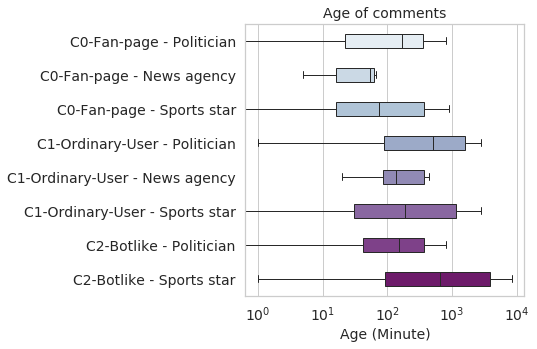

In [86]:
def plot_3():
    
    fig, (ax1) = plt.subplots(1,1, figsize=(5,5))
    LIST_DF_9 = [df_c0_politician, df_c0_newsagency, df_c0_sportsstar,
                df_c1_politician, df_c1_newsagency, df_c1_sportsstar,
                df_c2_politician, df_c2_newsagency, df_c2_sportsstar
                ]


    LIST_DF_9_NAME = [ 
        c0_name_fan + ' - Politician' , c0_name_fan + ' - News agency' , c0_name_fan + ' - Sports star',
        c1_name_ordinary + ' - Politician' , c1_name_ordinary + ' - News agency' , c1_name_ordinary + ' - Sports star',
        c2_name_botlike + ' - Politician' , c2_name_botlike + ' - News agency' , c2_name_botlike + ' - Sports star',
    ]

    list_box_plot = []
    for j in range(len(LIST_DF_9)):

        list_imposter_all = []
        item = LIST_DF_9[j]

        if (len(item['comment_age_sec']) > 0):

            for i in item['comment_age_sec']:
                if (not i == ""):
                    posts = i.split(",,,")
                    list_imposter_all.extend(posts)

            list_imposter_all = list(map(float, list_imposter_all))
            list_impostor_day = []
            list_impostor_min = []

            for i in list_imposter_all:
                # Obtain the total minutes
                totalMinutes = i // 60
                # Obtain the total hours
                totalHours = totalMinutes // 60
            #     sec = timedelta(seconds=i)
                totalday = totalHours // 24
                list_impostor_min.append(totalMinutes)
                list_impostor_day.append(totalHours)


            datam0 =  pd.DataFrame(list_impostor_min)
            datam0.columns = ['period']
            # print(list_impostor_day)
            data =  pd.DataFrame(list_impostor_day)
            data.columns = ['period']
        #     ser = data[['period']].copy()
        #     ser = ser.sort_values(by='period')
        #     ser[len(ser)] = ser.iloc[-1]
        #     cum_dist = np.linspace(0.,1.,len(ser))
        #     ser_cdf = pd.Series(cum_dist, index=ser)
        #     ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1, legend=True, label='XXX')
        #     ax5.axes.set_xlim([0,50])

        #     ax5.set_ylabel("CDF")
        #     ax5.set_xlabel("Comment Age (hour)")
        #     ax5.set_title("a) CDF of Comment age")


            s = datam0['period']
            s.name = LIST_DF_9_NAME[j]

            list_box_plot.append(s)



    data3 = pd.concat(list_box_plot, axis=1)

    ax2 = sns.boxplot( data=data3, showfliers=False, width= 0.4, linewidth=1, ax=ax1, orient="h", palette="BuPu")
    # plt.setp(boxplot2.get_xticklabels(), rotation=90)
    # boxplot2.plot(data3.mean(), 'rs')
    ax2.set_xlabel("Age (Minute)")
    ax2.set_ylabel("")
    ax2.set_xscale('log')
    ax2.set_title("Age of comments")


    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()): item.set_fontsize(14)

    plt.savefig("plot_MLearning9_P3.pdf", bbox_inches='tight')
    
plot_3()

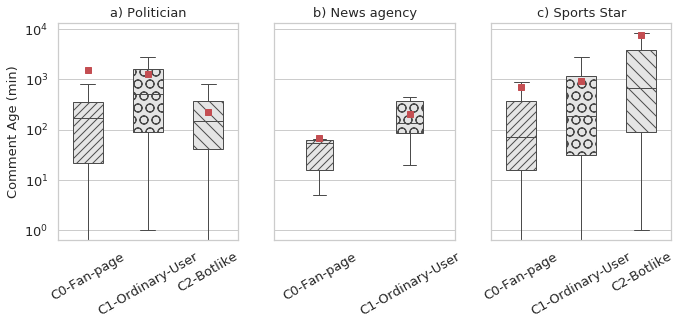

In [94]:
def plot_4():
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,4), sharey=True)

    LIST_DF_POLITICIAN = [df_c0_politician, df_c1_politician, df_c2_politician]
    LIST_DF_NEWSAGENCY = [df_c0_newsagency, df_c1_newsagency, df_c2_newsagency]
    LIST_DF_SPORTSSTAR = [df_c0_sportsstar, df_c1_sportsstar, df_c2_sportsstar]

    LIST_NAME = [c0_name_fan , c1_name_ordinary, c2_name_botlike]


    #politician
    list_box_plot = []
    for j in range(len(LIST_DF_POLITICIAN)):

        list_imposter_all = []
        item = LIST_DF_POLITICIAN[j]

        if (len(item['comment_age_sec']) > 0):

            for i in item['comment_age_sec']:
                if (not i == ""):
                    posts = i.split(",,,")
                    list_imposter_all.extend(posts)

            list_imposter_all = list(map(float, list_imposter_all))
            list_impostor_day = []
            list_impostor_min = []

            for i in list_imposter_all:
                # Obtain the total minutes
                totalMinutes = i // 60
                # Obtain the total hours
                totalHours = totalMinutes // 60
            #     sec = timedelta(seconds=i)
                totalday = totalHours // 24
                list_impostor_min.append(totalMinutes)
                list_impostor_day.append(totalHours)


            datam0 =  pd.DataFrame(list_impostor_min)
            datam0.columns = ['period']
            data =  pd.DataFrame(list_impostor_day)
            data.columns = ['period']

            s = datam0['period']
            s.name = LIST_NAME[j]
            list_box_plot.append(s)


    data3 = pd.concat(list_box_plot, axis=1)
    ax1 = sns.boxplot( data=data3, showfliers=False, width=0.5,  linewidth=1, ax=ax1)#, showmeans=True)
    ax1.plot(data3.mean(), 'rs')
    ax1.set_ylabel("Comment Age (min)")
    ax1.set_title("a) Politician")
    ax1.set_yscale('log')
    ax1.set_xticklabels(data3.columns, rotation=30, fontsize=8)

    mybox = ax1.artists[0]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '///')

    mybox = ax1.artists[1]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = 'O')

    mybox = ax1.artists[2]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '\\\ ')

    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()): item.set_fontsize(13)





    #News Agency
    list_box_plot = []
    for j in range(len(LIST_DF_NEWSAGENCY)):

        list_imposter_all = []
        item = LIST_DF_NEWSAGENCY[j]

        if (len(item['comment_age_sec']) > 0):

            for i in item['comment_age_sec']:
                if (not i == ""):
                    posts = i.split(",,,")
                    list_imposter_all.extend(posts)

            list_imposter_all = list(map(float, list_imposter_all))
            list_impostor_day = []
            list_impostor_min = []

            for i in list_imposter_all:
                # Obtain the total minutes
                totalMinutes = i // 60
                # Obtain the total hours
                totalHours = totalMinutes // 60
            #     sec = timedelta(seconds=i)
                totalday = totalHours // 24
                list_impostor_min.append(totalMinutes)
                list_impostor_day.append(totalHours)


            datam0 =  pd.DataFrame(list_impostor_min)
            datam0.columns = ['period']
            data =  pd.DataFrame(list_impostor_day)
            data.columns = ['period']

            s = datam0['period']
            s.name = LIST_NAME[j]
            list_box_plot.append(s)


    data3 = pd.concat(list_box_plot, axis=1)
    ax2 = sns.boxplot( data=data3, showfliers=False, width=0.3,  linewidth=1, ax=ax2)#, showmeans=True)
    ax2.plot(data3.mean(), 'rs')
    # ax2.set_ylabel("Comment Age (min)")
    ax2.set_title("b) News agency")
    ax2.set_yscale('log')
    ax2.set_xticklabels(data3.columns, rotation=30, fontsize=8)

    mybox = ax2.artists[0]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '///')

    mybox = ax2.artists[1]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = 'O')

    # mybox = ax2.artists[2]
    # mybox.set_facecolor('#e5e5e5')
    # mybox.set(hatch = '\\\')

    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()): item.set_fontsize(13)





    #Sports Star
    list_box_plot = []
    for j in range(len(LIST_DF_SPORTSSTAR)):

        list_imposter_all = []
        item = LIST_DF_SPORTSSTAR[j]

        if (len(item['comment_age_sec']) > 0):

            for i in item['comment_age_sec']:
                if (not i == ""):
                    posts = i.split(",,,")
                    list_imposter_all.extend(posts)

            list_imposter_all = list(map(float, list_imposter_all))
            list_impostor_day = []
            list_impostor_min = []

            for i in list_imposter_all:
                # Obtain the total minutes
                totalMinutes = i // 60
                # Obtain the total hours
                totalHours = totalMinutes // 60
            #     sec = timedelta(seconds=i)
                totalday = totalHours // 24
                list_impostor_min.append(totalMinutes)
                list_impostor_day.append(totalHours)


            datam0 =  pd.DataFrame(list_impostor_min)
            datam0.columns = ['period']
            data =  pd.DataFrame(list_impostor_day)
            data.columns = ['period']

            s = datam0['period']
            s.name = LIST_NAME[j]
            list_box_plot.append(s)


    data3 = pd.concat(list_box_plot, axis=1)
    ax3 = sns.boxplot( data=data3, showfliers=False, width=0.5,  linewidth=1, ax=ax3)#, showmeans=True)
    ax3.plot(data3.mean(), 'rs')
    # ax3.set_ylabel("Comment Age (min)")
    ax3.set_title("c) Sports Star")
    ax3.set_yscale('log')
    ax3.set_xticklabels(data3.columns, rotation=30, fontsize=8)

    mybox = ax3.artists[0]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '///')

    mybox = ax3.artists[1]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = 'O')

    mybox = ax3.artists[2]
    mybox.set_facecolor('#e5e5e5')
    mybox.set(hatch = '\\\ ' )

    for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] + ax3.get_xticklabels() + ax3.get_yticklabels()): item.set_fontsize(13)

    plt.savefig("plot_MLearning9_P4.pdf", bbox_inches='tight')
plot_4()